# <p align="center">Siemens Sales Forecast</p>

---

## <p align="center">*2 - Feature Selection & Modeling*</p>

---

### 👥 **Team Members**
- **Ana Farinha** *(Student Number: 20211514)*  
- **António Oliveira** *(Student Number: 20211595)*  
- **Mariana Neto** *(Student Number: 20211527)*  
- **Salvador Domingues** *(Student Number: 20240597)*  

📅 **Date:** *April 1, 2025*  
📍 **Prepared for:** *Siemens*  

**GitHub Repo:** https://github.com/MGN19/Siemens-forecast

---

# ToC

<a class="anchor" id="top"></a>


1. [Import Libraries & Data](#1.-Import-Libraries-&-Data) <br><br>

2. [Product Category #1](#Product-Category-#1) <br><br>

In [1]:
## CELL TYPES (remover depois)

<div class="alert-danger">
    
test

<div class="alert-warning">
    
test

<div class="alert-info">
    
test

# 1. Import Libraries & Data

In [1]:
import os
import pandas as pd

pd.set_option('display.max_columns', None)

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

import fs_modelling as fs

**Data**

In [2]:
X_train = pd.read_csv('./data/X_train_data/X_train.csv', index_col = 'Unnamed: 0')
X_val = pd.read_csv('./data/X_val_data/X_val.csv', index_col = 'Unnamed: 0')

def import_all_csvs_as_vars(folder):
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            df_name = file.replace('.csv', '')
            df = pd.read_csv(os.path.join(folder, file), index_col = 'Unnamed: 0')
            globals()[df_name] = df
            # print(f"Loaded {df_name}")

# Import each CSV file as individual DataFrames
import_all_csvs_as_vars('data/y_train_data')
import_all_csvs_as_vars('data/y_val_data')

# Product Category #1

<a href="#top">Top &#129033;</a>

In [3]:
datasets = [X_train, X_val, y_train_1, y_val_1]

**Scaling**

In [4]:
X_train_scaled, X_val_scaled = fs.scale_data(X_train, 
                                          X_val, 
                                          scaler_type='minmax')

## 2.1 Feature Selection

Selected 41 features by correlation


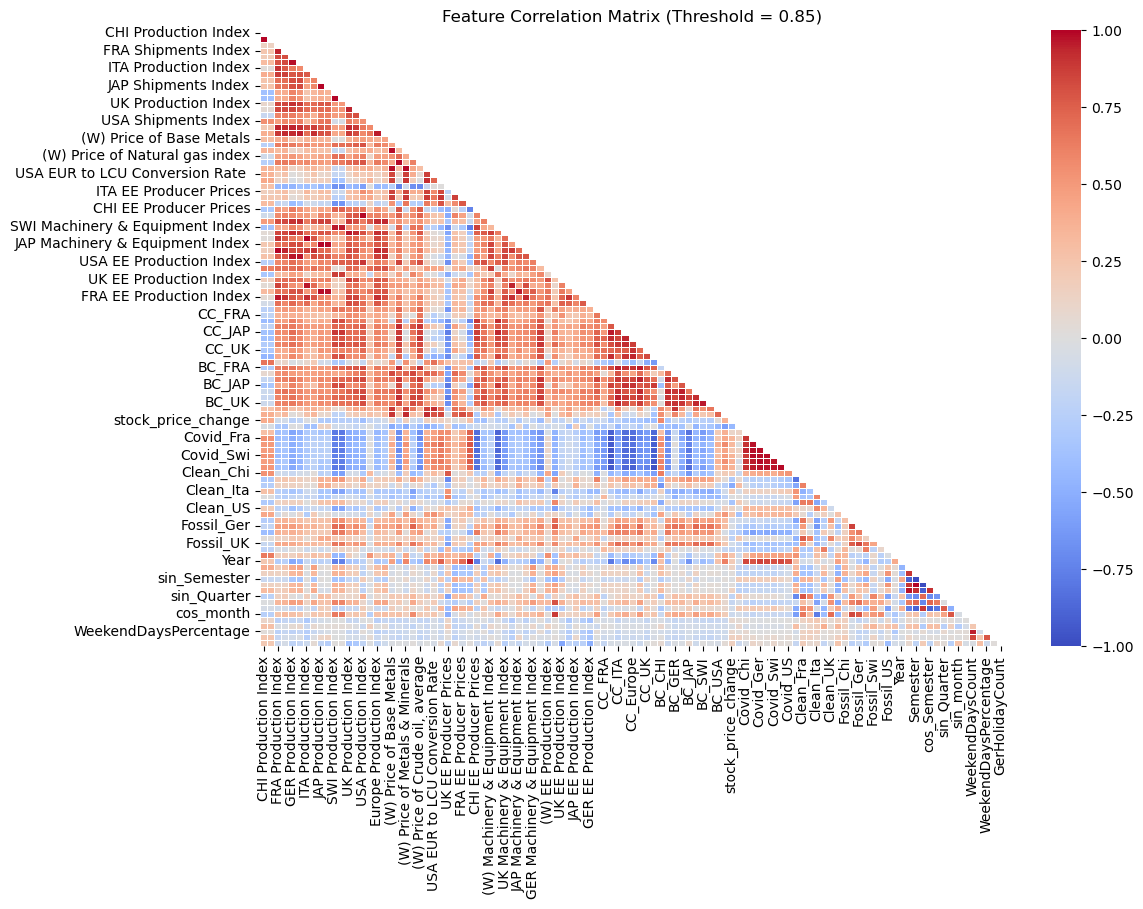

Selected 104 features by RFECV


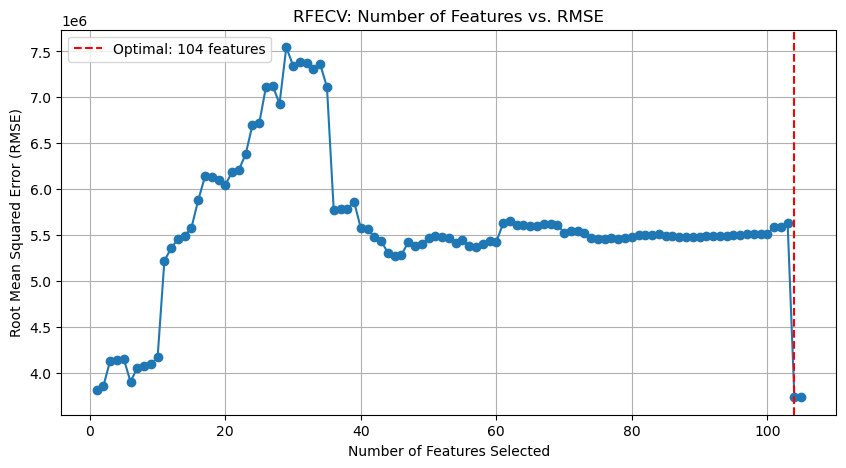

Selected 24 features by importance with threshold 0.009523809523809525


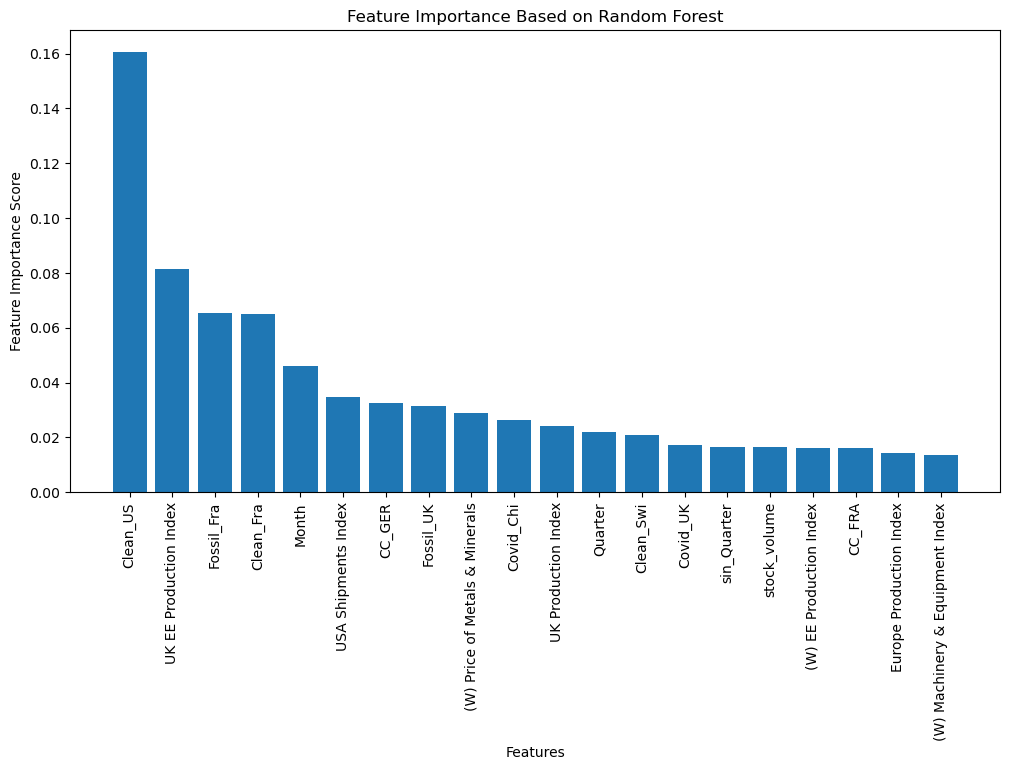

Selected 1 features by Lasso regularization


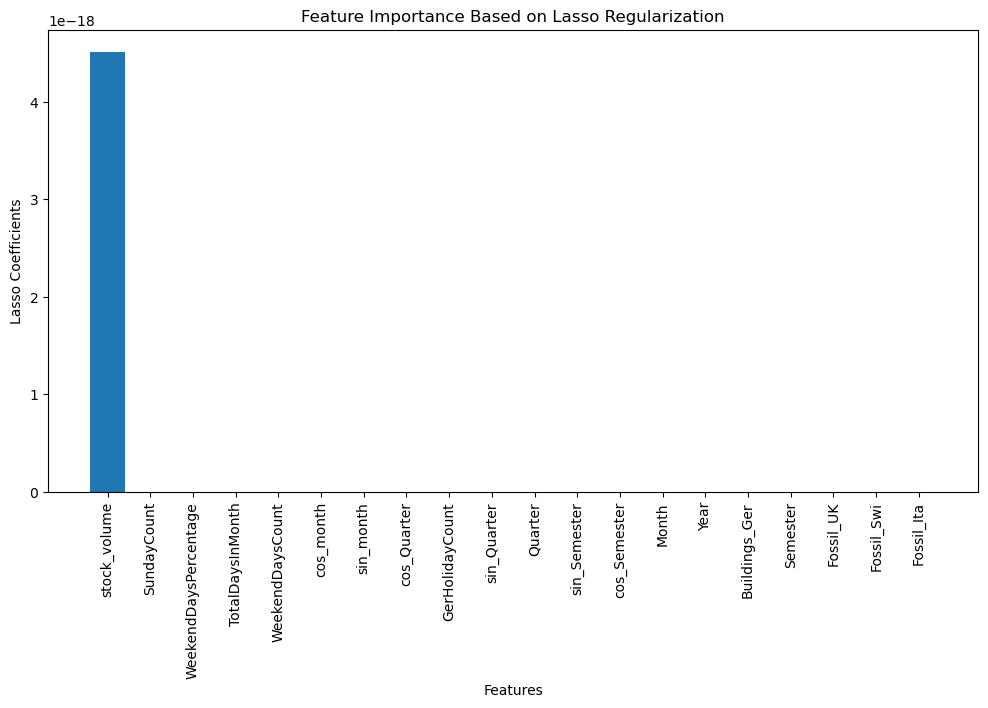

Selected 1 features that intersect across all methods


['stock_volume']

In [6]:
fs.feature_selection(X_train, y_train_1, method='all', rfe_model=None, 
                      corr_threshold=0.85, importance_threshold='mean', plot=True)

## 2.2 Model Training

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import matplotlib.pyplot as plt
#from pmdarima import auto_arima

In [23]:
def stats_models(model_type,  X_train, X_val, y_train, y_val,
                 order=(1,1,1), seasonal_order=(1,1,1,12),
                 plot = False):

    if model_type == 'arima':
        model = ARIMA(y_train, order=order)
        model_fit = model.fit()
        train_preds = model_fit.fittedvalues
        val_preds = model_fit.forecast(steps=len(y_val))
                                      
    elif model_type == 'sarimax':
        model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order, exog=X_train)
        model_fit = model.fit()
        train_preds = model_fit.fittedvalues
        val_preds = model_fit.forecast(steps=len(y_val), exog=X_val)

    elif model_type == 'prophet':
        df_train = y_train.reset_index()
        df_train.columns = ['ds', 'y']
        
        model = Prophet()
        model.fit(df_train)

        # Create future DataFrame
        future = pd.DataFrame({'ds': y_val.index})
        forecast_df = model.predict(future)
        val_preds = forecast_df.set_index('ds')['yhat'] 

        train_preds = None
        model_fit = None
    
    else:
        raise ValueError("Invalid model_type. Choose 'arima', 'sarima', or 'prophet'.")

    if plot:
        plt.figure(figsize=(12, 6))

        plt.plot(y_train.index, y_train, label='Actual Train', color='blue')
        plt.plot(y_val.index, y_val, label='Actual Validation', color='green')
        plt.plot(y_val.index, val_preds, label='Predicted Validation', color='red')

        plt.legend()
        plt.title(f'{model_type.upper()} Model - Training and Validation Predictions')
        plt.xlabel('Time')
        plt.xticks(rotation=45)
        plt.ylabel('Value')
        plt.show()


    return model_fit, val_preds, model_fit.summary() if model_type != 'prophet' else val_preds

/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


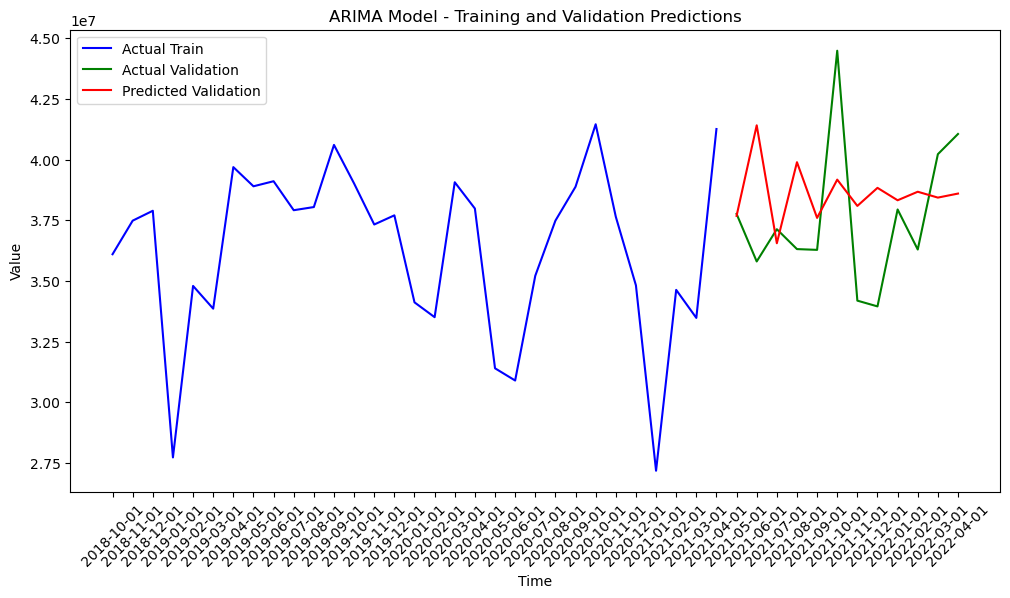

/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


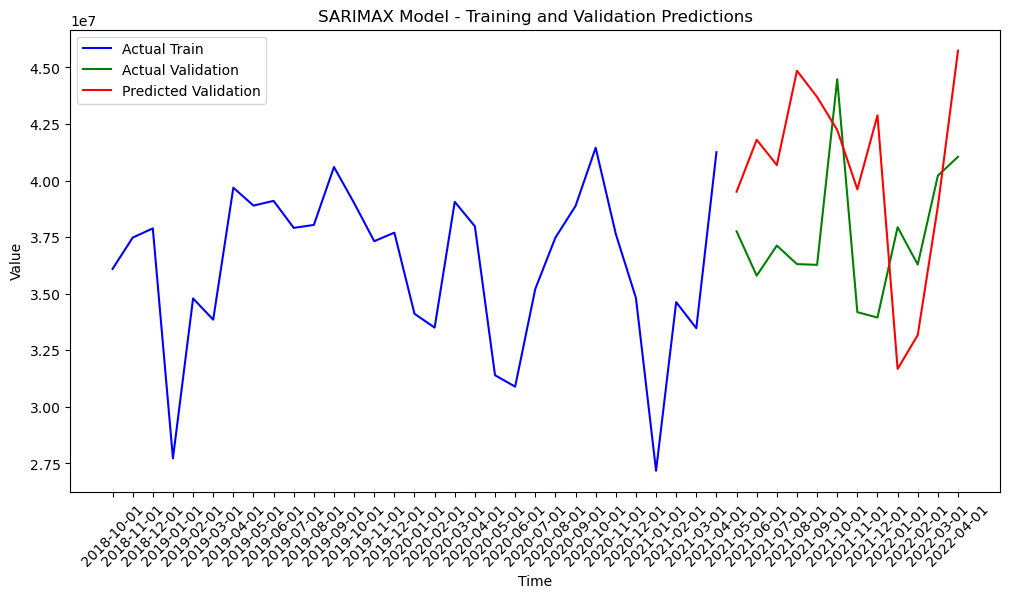

10:19:18 - cmdstanpy - INFO - Chain [1] start processing
10:19:18 - cmdstanpy - INFO - Chain [1] done processing


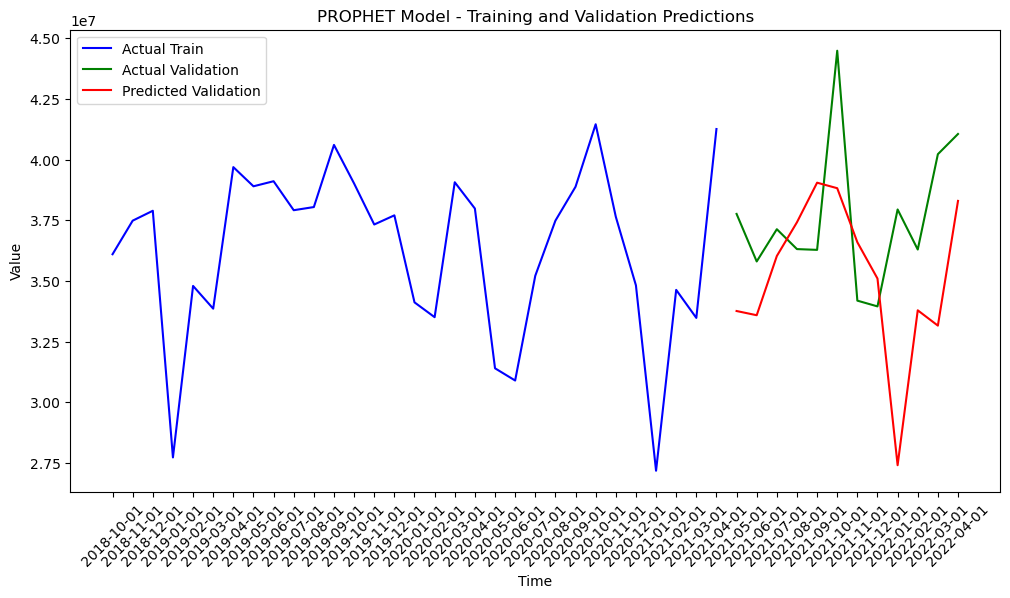

In [34]:
model_ar, val_preds_ar, summary_ar = stats_models('arima', X_train, X_val, 
                                            y_train_1, y_val_1, order=(1,1,3),
                                                 plot = True)

model_sarx, val_preds_sarx, summary_sarx = stats_models('sarimax', X_train, X_val, 
                                            y_train_1, y_val_1, seasonal_order=(1,1,1,12),
                                                       plot = True)

val_preds_p = stats_models('prophet', X_train, X_val, 
                                            y_train_1, y_val_1,
                          plot = True)


In [16]:
print(summary_ar)
print(summary_sarx)
print(val_preds_p)

                               SARIMAX Results                                
Dep. Variable:                     #1   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -497.930
Date:                Thu, 27 Mar 2025   AIC                           1001.860
Time:                        10:15:00   BIC                           1006.064
Sample:                    10-01-2018   HQIC                          1003.205
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9095      0.135     -6.757      0.000      -1.173      -0.646
ma.L1          0.8408      0.176      4.784      0.000       0.496       1.185
sigma2      1.405e+13    2.6e-15   5.41e+27      0.0

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def stats_models(model_type, X_train, X_val, y_train, y_val,
                 order=(1,1,1), seasonal_order=(1,1,1,12), plot=False, csv_path=None):

    """
    Train and evaluate time series forecasting models (ARIMA, SARIMAX, Prophet).
    
    Parameters:
    ----------
    model_type : str
        The type of model to use. Options: 'arima', 'sarimax', or 'prophet'.
    X_train : pd.DataFrame or None
        Training features (only used for SARIMAX, ignored for ARIMA and Prophet).
    X_val : pd.DataFrame or None
        Validation features (only used for SARIMAX, ignored for ARIMA and Prophet).
    y_train : pd.Series
        Training target variable (time series data).
    y_val : pd.Series
        Validation target variable (time series data).
    order : tuple, default=(1,1,1)
        ARIMA/SARIMAX model parameters (p, d, q) for non-seasonal components.
    seasonal_order : tuple, default=(1,1,1,12)
        SARIMAX model parameters (P, D, Q, S) for seasonal components.
    plot : bool, default=False
        If True, plots the actual vs. predicted values for the validation set.
    csv_path : str or None, default=None
        If specified, appends model performance metrics to the given CSV file.
    
    Returns:
    -------
    model_fit : statsmodels or None
        The trained model object (ARIMA/SARIMAX). Returns None for Prophet.
    val_preds : pd.Series
        Predictions for the validation set.
    summary : statsmodels summary object or pd.Series
        Model summary for ARIMA/SARIMAX, or validation predictions for Prophet.
    """

    train_rmse, val_rmse, train_mape, val_mape = None, None, None, None  

    if model_type == 'arima':
        model = ARIMA(y_train, order=order)
        model_fit = model.fit()
        train_preds = model_fit.fittedvalues
        val_preds = model_fit.forecast(steps=len(y_val))

    elif model_type == 'sarimax':
        model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order, exog=X_train)
        model_fit = model.fit()
        train_preds = model_fit.fittedvalues
        val_preds = model_fit.forecast(steps=len(y_val), exog=X_val)

    elif model_type == 'prophet':
        df_train = y_train.reset_index()
        df_train.columns = ['ds', 'y']
        
        model = Prophet()
        model.fit(df_train)

        future = pd.DataFrame({'ds': y_val.index})
        forecast_df = model.predict(future)
        val_preds = forecast_df.set_index('ds')['yhat']

        train_preds = None
        model_fit = model

    else:
        raise ValueError("Invalid model_type. Choose 'arima', 'sarimax', or 'prophet'.")

    # Calculate Error Metrics
    if train_preds is not None:
        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
        train_mape = mean_absolute_percentage_error(y_train, train_preds) * 100

    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    val_mape = mean_absolute_percentage_error(y_val, val_preds) * 100

    # Optional Plot
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(y_train.index, y_train, label='Actual Train', color='blue')
        plt.plot(y_val.index, y_val, label='Actual Validation', color='green')
        plt.plot(y_val.index, val_preds, label='Predicted Validation', color='red')

        plt.legend()
        plt.title(f'{model_type.upper()} Model - Training and Validation Predictions')
        plt.xlabel('Time')
        plt.xticks(rotation=45)
        plt.ylabel('Value')
        plt.show()

    # Collect results
    results = {
        "model_type": model_type,
        "features_used": X_train.columns.tolist() if model_type != 'arima' else "N/A",
        "train_rmse": train_rmse,
        "val_rmse": val_rmse,
        "train_mape (%)": train_mape,
        "val_mape (%)": val_mape
    }

    # Save results to CSV if a path is specified
    if csv_path:
        results_df = pd.DataFrame([results])  # Convert dict to DataFrame
        
        # Check if file exists to determine mode
        if os.path.exists(csv_path):
            results_df.to_csv(csv_path, mode='a', header=False, index=False)
        else:
            results_df.to_csv(csv_path, mode='w', header=True, index=False)
        
        print(f"Results appended to {csv_path}")

    if model_type == 'prophet':
        return model_fit, val_preds  
    else:
        return model_fit, val_preds, model_fit.summary()


**ARIMA**

In [89]:
model_fit_ar, val_preds_ar, model_summary_ar = stats_models('arima', X_train, X_val, 
                                     y_train_1, y_val_1, order=(1,1,3),
                                     plot = False, 
                                     csv_path = './modelling_csvs/test3.csv')

Results appended to ./modelling_csvs/test3.csv


/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [76]:
steps_ahead = 10  # Number of future steps you want to predict
future_preds = model_fit_ar.forecast(steps=steps_ahead)
print(future_preds)


2021-05-01    3.767997e+07
2021-06-01    4.141062e+07
2021-07-01    3.655150e+07
2021-08-01    3.989044e+07
2021-09-01    3.759609e+07
2021-10-01    3.917265e+07
2021-11-01    3.808932e+07
2021-12-01    3.883372e+07
2022-01-01    3.832221e+07
2022-02-01    3.867370e+07
Freq: MS, Name: predicted_mean, dtype: float64


**SARIMAX**

In [90]:
model_fit_sarx, val_preds_sarx, model_summary_sarx = stats_models('sarimax', X_train, X_val, 
                                     y_train_1, y_val_1, order=(1,1,3),
                                     plot = False, 
                                     csv_path = './modelling_csvs/test3.csv')

/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/bcwds2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results appended to ./modelling_csvs/test3.csv


In [83]:
X_future = X_val # temp
future_preds = model_fit_sarx.forecast(steps=len(X_future), exog=X_future)
print(future_preds)


2021-05-01    3.951051e+07
2021-06-01    4.180620e+07
2021-07-01    4.068981e+07
2021-08-01    4.485621e+07
2021-09-01    4.369701e+07
2021-10-01    4.223861e+07
2021-11-01    3.961871e+07
2021-12-01    4.288582e+07
2022-01-01    3.167765e+07
2022-02-01    3.317506e+07
2022-03-01    3.887002e+07
2022-04-01    4.574127e+07
Freq: MS, Name: predicted_mean, dtype: float64


**Prophet**

10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing


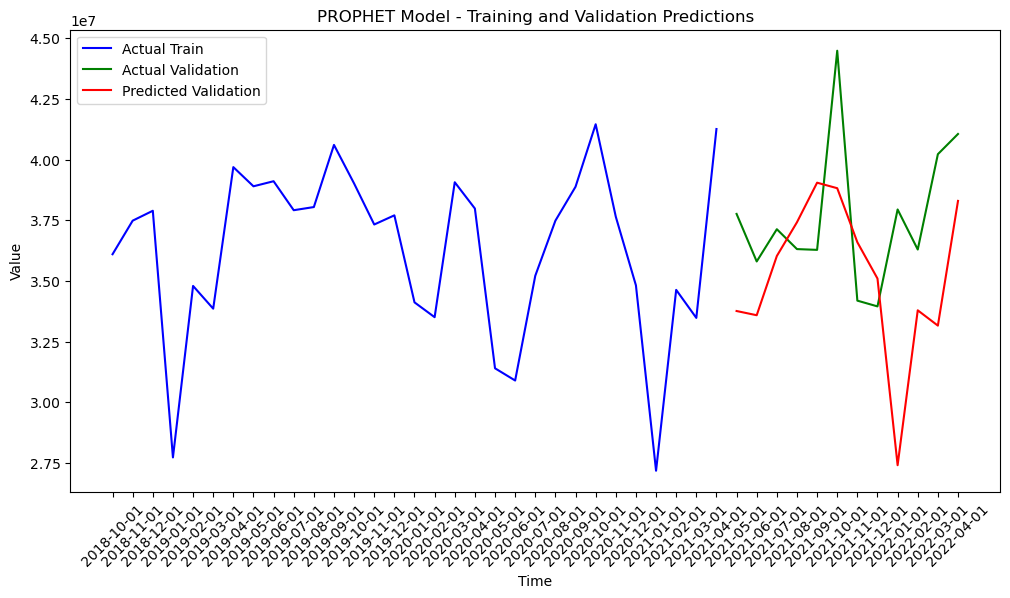

Results appended to ./modelling_csvs/test3.csv


In [91]:
model_fit_prof, val_preds_prof = stats_models('prophet', X_train, X_val, 
                                 y_train_1, y_val_1, order=(1,1,3),
                                 plot = True, 
                                 csv_path = './modelling_csvs/test3.csv')


In [80]:
future_dates = pd.date_range(start='2022-04-01', periods=10, freq='M')
future_df = pd.DataFrame({'ds': future_dates})

future_preds = model_fit_prof.predict(future_df) 
print(future_preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


          ds          yhat    yhat_lower    yhat_upper
0 2022-04-30  4.022729e+07  3.848470e+07  4.212845e+07
1 2022-05-31  4.029798e+07  3.856007e+07  4.212756e+07
2 2022-06-30  3.390558e+07  3.222865e+07  3.577783e+07
3 2022-07-31  3.338732e+07  3.142394e+07  3.518023e+07
4 2022-08-31  3.849076e+07  3.674057e+07  4.030711e+07
5 2022-09-30  3.176397e+07  3.001308e+07  3.356449e+07
6 2022-10-31  3.609832e+07  3.420550e+07  3.788512e+07
7 2022-11-30  4.059999e+07  3.867652e+07  4.257146e+07
8 2022-12-31  3.681564e+07  3.507082e+07  3.857219e+07
9 2023-01-31  2.998908e+07  2.816692e+07  3.178522e+07


**Results**

In [92]:
test3 = pd.read_csv('modelling_csvs/test3.csv')
test3

,model_type,features_used,train_rmse,val_rmse,train_mape (%),val_mape (%)
0,arima,NaN,7.150329e+06,3.274455e+06,9.917684,7.220678
1,sarimax,"['CHI Production Index', 'CHI Shipments Index'...",4.959269e+06,5.530280e+06,6.760927,13.509213
2,prophet,"['CHI Production Index', 'CHI Shipments Index'...",NaN,4.517790e+06,NaN,9.376255


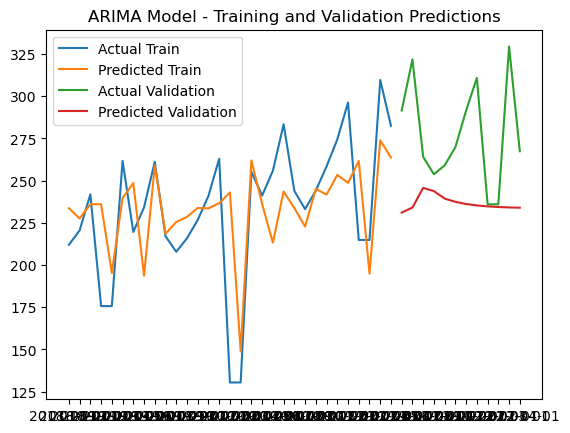

In [208]:
# Plot the training predictions
plt.plot(X_train.index, X_train[a], label='Actual Train')
plt.plot(X_train.index, train_preds, label='Predicted Train')

# Plot the validation predictions
plt.plot(X_val.index, X_val[a], label='Actual Validation')
plt.plot(X_val.index, val_preds, label='Predicted Validation')

plt.legend()
plt.title('ARIMA Model - Training and Validation Predictions')
plt.show()


,Unnamed: 0,#1
0,2018-10-01,36098918.79
1,2018-11-01,37482085.58
2,2018-12-01,37889612.12
3,2019-01-01,27728148.35
4,2019-02-01,34793163.53
5,2019-03-01,33856803.04
6,2019-04-01,39688292.01
7,2019-05-01,38897974.29
8,2019-06-01,39106750.23
9,2019-07-01,37912572.30


In [47]:
import pandas as pd
import numpy as np
import os
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.utils import all_estimators

def modelling(X_train, y_train, X_test, y_test, 
              features_used, 
              metric='RMSE', 
              model_choice='arima', 
              save_filename=None):

    save_folder = './modelling_csvs'
    if save_filename is None:
        raise ValueError('Need to name save file')
    else:
        save_path = os.path.join(save_folder, save_filename)

    if model_choice == 'arima':
        if len(features_used) > 1:
            raise ValueError('ARIMA only accepts 1 feature for the target variable.')

        model = ARIMA(y_train, order=(1, 1, 1))
        model_fit = model.fit()

        # Train RMSE (in-sample prediction)
        train_predictions = model_fit.predict(start=0, end=len(y_train)-1, dynamic=False)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

        # Test RMSE
        predictions = model_fit.forecast(len(y_test))
        val_rmse = np.sqrt(mean_squared_error(y_test, predictions))

        best_model_name = 'ARIMA'
        best_score = val_rmse

        print(f'ARIMA Train RMSE: {train_rmse}')
        print(f'ARIMA Validation RMSE: {val_rmse}')

        
    elif model_choice == 'lazy':
        regressor = LazyRegressor(verbose=0)
        models, _ = regressor.fit(X_train[features_used], X_test[features_used], y_train, y_test)

        best_model_name = models.sort_values(by=metric).iloc[0].name
        
        regressors = dict(all_estimators(type_filter='regressor'))
        model = regressors[best_model_name]()

        model.fit(X_train[features_used], y_train)

        train_preds = model.predict(X_train[features_used])
        test_preds = model.predict(X_test[features_used])

        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
        val_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

        best_score = val_rmse

        print(f'Best model: {best_model_name}')
        print(f'Train RMSE: {train_rmse}')
        print(f'Validation RMSE: {val_rmse}')

    elif model_choice == 'prophet':
        raise ValueError('NOT WORKING YET')

    result_row = {
        'Features Used': ', '.join(features_used),
        'Best Model': best_model_name,
        'Train RMSE': train_rmse,
        'Validation RMSE': val_rmse
    }

    results_df = pd.DataFrame([result_row])
    results_df.to_csv(save_path, mode='a', header=not os.path.isfile(save_path), index=False)

    return best_model_name, train_rmse, val_rmse



In [49]:
best_model_name, best_score_train, best_score_val  = modelling(X_train_scaled, y_train_1, X_val_scaled, y_val_1, 
              features_used=selected_features, 
              metric='RMSE', 
              model_choice='lazy',
              save_filename = 'categ1_new.csv')

100%|████████████████████████████████████████| 42/42 [00:01<00:00, 29.55it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 36294712.838710
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

In [46]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_squared_error

def prophet_forecast(X_train, y_train, features_used, periods=10, freq='MS'):
    """
    Function to perform forecasting using Prophet for each feature in 'features_used'.

    Parameters:
    - X_train: DataFrame containing the training data
    - y_train: Actual ground truth values for RMSE calculation (training data)
    - features_used: List of features/columns to forecast using Prophet
    - periods: Number of future periods to predict (default=10)
    - freq: Frequency of the periods (default='MS' for monthly start)

    Returns:
    - best_model_name: Name of the best model ('prophet')
    - best_score: The lowest RMSE score for the model
    """
    best_score = float('inf')
    best_model_name = None

    # Initialize an empty DataFrame to hold future feature values
    future_features = pd.DataFrame()

    # Iterate through each column in 'features_used'
    for column in features_used:
        # Isolate the current column into a new DataFrame 'df1'
        df1 = X_train[[column]].copy()

        # Reset the index of 'df1' and rename columns to fit Prophet's expected format
        data = (df1.reset_index()
                .rename(columns={'index': 'ds', f'{column}': 'y'}))

        # Initialize Prophet model
        model = Prophet()

        # Fit the model to the data
        model.fit(data)

        # Create a DataFrame representing future dates to make predictions
        future = model.make_future_dataframe(periods=periods, freq=freq)

        # Forecast future dates
        forecast_index = model.predict(future)

        # Select relevant columns ('ds' for date, 'yhat' for predictions)
        forecast_index = forecast_index[['ds', 'yhat']]

        # Set the date column as the index
        forecast_index = forecast_index.set_index('ds')

        # Add the forecasted values to the 'future_features' DataFrame
        future_features[column] = forecast_index['yhat'].values

    # Reset the index of the future_features DataFrame to use 'ds' as a regular column
    future_features.reset_index(inplace=True)

    # Add the date column to 'future_features'
    future_features['ds'] = forecast_index.index.values

    # Set 'ds' as the index of 'future_features'
    future_features.set_index('ds', inplace=True)

    # Ensure we only compare the forecasted values against a valid subset of y_train
    # For simplicity, we will compare the mean of the forecasted values to the corresponding `y_train` values
    predicted_values = future_features[features_used].mean(axis=1)  # For simplicity, take the mean of all predictions

    rmse = mean_squared_error(y_train, predicted_values)

    # Compare RMSE to get the best model
    if rmse < best_score:
        best_score = rmse
        best_model_name = 'prophet'

    return best_model_name, best_score


In [47]:
prophet_forecast(X_train_1_scaled, y_train_1, selected_features) 

11:44:03 - cmdstanpy - INFO - Chain [1] start processing
11:44:03 - cmdstanpy - INFO - Chain [1] done processing
11:44:03 - cmdstanpy - INFO - Chain [1] start processing
11:44:03 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found input variables with inconsistent numbers of samples: [31, 41]

In [34]:
!pip install statsmodels

  Using cached statsmodels-0.14.4-cp313-cp313-macosx_10_13_x86_64.whl.metadata (9.2 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp313-cp313-macosx_10_13_x86_64.whl (10.2 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)


In [42]:
X_train_1_selected = X_train_1_scaled[selected_features]
X_val_1_selected = X_val_1_scaled[selected_features]

best_model_name, best_score = modelling(
    X_train_1_selected, y_train_1, X_val_1_selected, y_val_1, 
    features_used=selected_features, metric='RMSE'
)

100%|██████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 34.63it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 36289610.258065
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

In [67]:
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np

# def lazy_regressor(X_train, y_train, X_test, y_test, metric='RMSE'):
    
#     # Initialize LazyRegressor
#     regressor = LazyRegressor(verbose=0)
    
#     # Fit the model
#     models, predictions = regressor.fit(X_train, X_test, y_train, y_test)
    
#     # Select the best model based on the metric (e.g., RMSE)
#     best_model = models.sort_values(by=metric).iloc[0]
    
#     # Get the model name and the best score
#     best_model_name = best_model.name
#     best_score = best_model[metric]
    
#     print(f'Best model: {best_model_name}')
#     print(f'{metric} of the best model: {best_score}')
    
#     # Return the best model and score
#     return best_model_name, best_score


In [68]:
# best_model_name, best_score = lazy_regressor(X_train_1_scaled, y_train_1,
#                                              X_val_1_scaled, y_val_1,
#                                              metric='RMSE')


100%|████████████████████████████████████| 42/42 [00:02<00:00, 17.66it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 36289610.258065
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

In [43]:
file = pd.read_csv('./lazy_regressor_results.csv')
file

,Features Used,Best Model,RMSE
0,"(W) Price of Base Metals, GER Production Index...",SVR,2887703.96
1,USA Shipments Index_Rolling_Mean_3,HuberRegressor,2823366.38
2,"BC_CHI, USA Shipments Index_Rolling_Mean_3, CH...",HuberRegressor,2830173.62
3,"(W) Price of Base Metals, GER Production Index...",SVR,2887703.92
4,"(W) Price of Natural gas index, USA Production...",SVR,2887703.88


In [75]:
from autosklearn.experimental.askl2 import ForecasterAutoregMultiSeries
from sklearn.metrics import mean_squared_error
import numpy as np

def time_series_forecasting(X_train, y_train, X_test, y_test, 
                            forecast_steps=10, metric='neg_root_mean_squared_error'):

    # Initialize ForecasterAutoregMultiSeries
    forecaster = ForecasterAutoregMultiSeries(steps=forecast_steps, metric=metric)
    
    # Fit the forecaster with training data
    forecaster.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = forecaster.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Test RMSE: {rmse}')
    
    return forecaster, y_pred, rmse


ModuleNotFoundError: No module named 'autosklearn'

## Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Fit the model using the training data
model.fit(X_train_1_scaled, y_train_1)

# Make predictions on the validation set
y_pred_val_1 = model.predict(X_val_1_scaled)

# Calculate RMSE for the validation set
rmse_val_1 = np.sqrt(mean_squared_error(y_val_1, y_pred_val_1))
print(f'Root Mean Squared Error on Validation Set: {rmse_val_1}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(y_val_1.index, y_val_1, label='Actual Validation Values', linestyle='-', color='g')
plt.plot(y_val_1.index, y_pred_val_1, label='Predicted Validation Values', linestyle='--', color='g')

plt.plot(y_train_1.index, y_train_1, label='Actual Training Values', linestyle='-', color='b')

plt.xlabel('Date/Time')
plt.ylabel('Sales')
plt.title('XGBoost Forecasting: Actual vs Predicted (Training and Validation)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
